In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from collections import defaultdict

In [2]:
plt.rcParams['font.family'] = ['SimHei']  # 设置字体为‘SimHei’
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

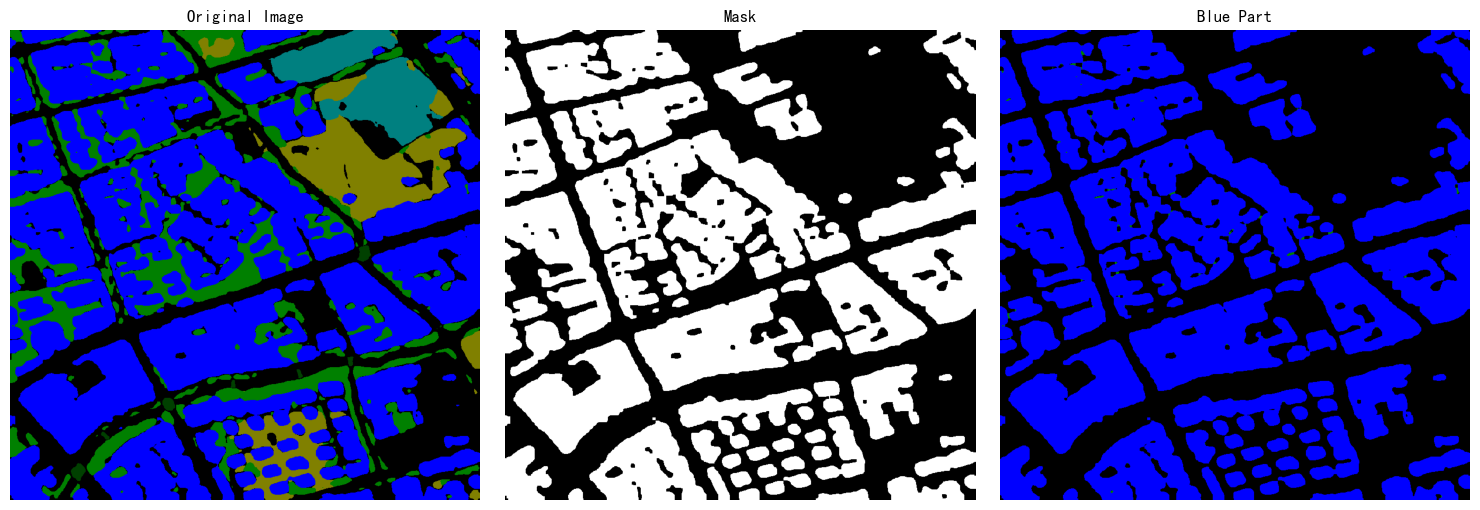

'C:\\Users\\11054\\Desktop\\hust\\Question1\\blue_part.png'

In [3]:
# 读取图像
image_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\download.png')
image = cv2.imread(image_path)

# 将图像从 BGR 转换到 HSV 颜色空间
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 定义 HSV 中蓝色的范围 110~130
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# 阈值 HSV 图像，获取蓝色范围
mask = cv2.inRange(hsv, lower_blue, upper_blue)

#  去除噪点 & 填充蓝色区域中的小洞
kernel = np.ones((5,5),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 使用蒙版获取原图像中的蓝色部分
blue_part = cv2.bitwise_and(image, image, mask=mask)

# 保存蓝色部分图像
output_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\blue_part.png')
cv2.imwrite(output_path, blue_part)

# 显示原图、蒙版和蓝色部分
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(blue_part, cv2.COLOR_BGR2RGB))
plt.title('Blue Part')
plt.axis('off')

plt.tight_layout()
plt.show()

output_path


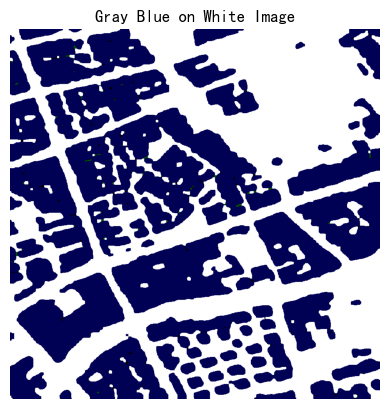

'C:\\Users\\11054\\Desktop\\hust\\Question1\\blue_gray_blue_white_image.png'

In [4]:
# 使用之前生成的mask，将非蓝色区域变为白色
# 白色在BGR中表示为(255, 255, 255)
white_background = np.full(image.shape, 255, dtype=image.dtype)
# 只在非蓝色区域应用白色背景
non_blue_part = cv2.bitwise_and(white_background, white_background, mask=~mask)

# 蓝色区域变为灰色，取蓝色部分的平均值作为灰度值
# 灰色在BGR中表示为相同的值(即平均值)
blue_to_gray = blue_part.copy()
blue_gray_value = cv2.mean(blue_to_gray, mask=mask)[:3]
gray_value = int(np.mean(blue_gray_value))
blue_to_gray[blue_to_gray > 0] = gray_value

# 将变为灰色的蓝色区域与白色背景合并
gray_blue_white_image = cv2.add(blue_to_gray, non_blue_part)

# 保存灰度图像
output_gray_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\blue_gray_blue_white_image.png')
cv2.imwrite(output_gray_path, gray_blue_white_image)

# 显示灰度图像
plt.imshow(cv2.cvtColor(gray_blue_white_image, cv2.COLOR_BGR2RGB))
plt.title('Gray Blue on White Image')
plt.axis('off')
plt.show()

output_gray_path

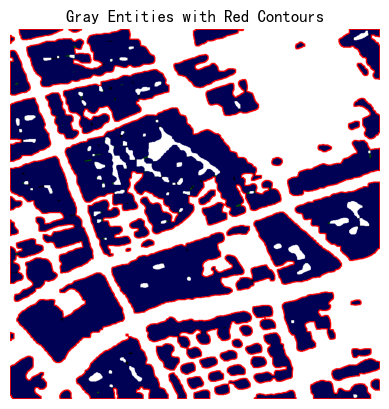

True

In [5]:
# 载入处理好的图像，其中蓝色部分变为灰色，其余变为白色
gray_blue_white_image = cv2.imread(output_gray_path)

# 寻找灰色实体的轮廓
# 将图像转换为灰度图像
gray = cv2.cvtColor(gray_blue_white_image, cv2.COLOR_BGR2GRAY)

# 设置阈值以仅保留灰色实体
_, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# 查找轮廓
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 在原图上绘制红色轮廓，保留灰色实体
cv2.drawContours(gray_blue_white_image, contours, -1, (0, 0, 255), 2)

# 显示图像
plt.imshow(cv2.cvtColor(gray_blue_white_image, cv2.COLOR_BGR2RGB))
plt.title('Gray Entities with Red Contours')
plt.axis('off')
plt.show()

# 保存结果图像
output_contoured_gray_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\gray_entities_with_red_contours.png')
cv2.imwrite(output_contoured_gray_path, gray_blue_white_image)

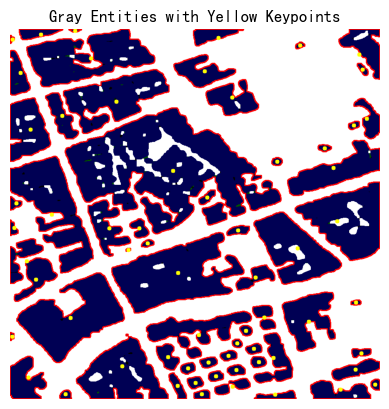

('C:\\Users\\11054\\Desktop\\hust\\Question1\\gray_entities_with_keypoints.png',
 'C:\\Users\\11054\\Desktop\\hust\\Question1\\keypoints_coordinates.xlsx')

In [6]:
# 使用边界矩形的中心，它应该在实体内部。

# 加载图像并转换为灰度图像
gray_blue_white_image = cv2.imread(output_contoured_gray_path)
gray = cv2.cvtColor(gray_blue_white_image, cv2.COLOR_BGR2GRAY)

# 设定阈值以保留灰色实体
_, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# 找到灰色实体的轮廓
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 获取图像高度，以将y坐标转换为常规笛卡尔坐标系
height = gray_blue_white_image.shape[0]

# 存储关键点及其数据的列表
keypoints = []
keypoints_data = []

# 遍历轮廓
for contour in contours:
    # 为每个轮廓计算边界矩形
    x, y, w, h = cv2.boundingRect(contour)
    
    # 将边界矩形的中心作为关键点
    cX = x + w // 2
    cY = (y + h // 2)  # 转换y坐标
    
    # 将点添加到关键点列表中，并在图像上绘制
    keypoints.append((cX, cY))
    keypoints_data.append({'x': cX, 'y': cY})
    cv2.circle(gray_blue_white_image, (cX, cY), 5, (0, 255, 255), -1)

# 显示黄色关键点图像
plt.imshow(cv2.cvtColor(gray_blue_white_image, cv2.COLOR_BGR2RGB))
plt.title('Gray Entities with Yellow Keypoints')
plt.axis('off')
plt.show()

# 保存修改后的图像
output_image_with_keypoints_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\gray_entities_with_keypoints.png')
cv2.imwrite(output_image_with_keypoints_path, gray_blue_white_image)

# 将关键点数据转换为数据框
df_keypoints_accurate = pd.DataFrame(keypoints_data)

# 将关键点数据保存到Excel文件
keypoints_excel_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\keypoints_coordinates.xlsx')
df_keypoints_accurate.to_excel(keypoints_excel_path, index=False)

# 返回带有准确关键点的图像和Excel文件的新路径
output_image_with_keypoints_path, keypoints_excel_path


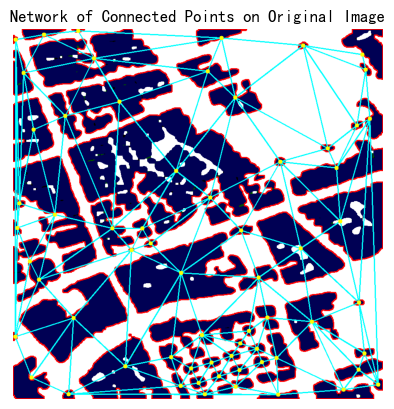

True

In [7]:
# 读取关键点坐标
excel_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\keypoints_coordinates.xlsx')
df_keypoints = pd.read_excel(excel_path)
points = df_keypoints.to_numpy()

# 载入图像
keypoints2_image_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\gray_entities_with_keypoints.png')
image = cv2.imread(keypoints2_image_path)
# 应用 Delaunay 三角剖分
tri = Delaunay(points)

# 根据 Delaunay三角剖分绘制连接线
for simplex in tri.simplices:
    for i in range(3):
        pt1 = tuple(points[simplex[i]])
        pt2 = tuple(points[simplex[(i+1) % 3]])
        cv2.line(image, pt1, pt2, (255, 255, 0), 2)  # 使用蓝绿黄色线条

# 再次绘制黄色关键点
for x, y in points:
    cv2.circle(image, (x, y), 5, (0, 255, 255), -1) 

# 显示图像
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Network of Connected Points on Original Image')
plt.axis('off')
plt.show()

# 保存结果
output_network_image_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\gray_entities_with_network.png')
cv2.imwrite(output_network_image_path, image)


In [8]:
# 字典存储每个点及其相连点关系
point_connections = defaultdict(set)

# 遍历Delaunay三角剖分的每个单纯形，提取点对
for simplex in tri.simplices:
    for i in range(3):
        pt1 = points[simplex[i]]
        pt2 = points[simplex[(i+1) % 3]]
        # 将点对添加到字典中
        point_connections[tuple(pt1)].add(tuple(pt2))
        point_connections[tuple(pt2)].add(tuple(pt1))

# 计算最大连接数
max_connections = max(len(connections) for connections in point_connections.values())

# 创建列名
columns = ['Point'] + [f'Connected_Point_{i+1}' for i in range(max_connections)]

# 创建一个列表来存储所有行的数据
data = []
for point, connected_points in point_connections.items():
    row = [point] + list(connected_points) + [None] * (max_connections - len(connected_points))
    data.append(row)

# 从列表创建DataFrame
df_connections = pd.DataFrame(data, columns=columns)

# 保存DataFrame为Excel文件
output_excel_path = os.path.join(r'C:\Users\11054\Desktop\hust\Question1\point_connections.xlsx')
df_connections.to_excel(output_excel_path, index=False)